In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
from geopy.geocoders import Nominatim

In [40]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [41]:
amazon_del = pd.read_csv("amazon_delivery.csv")
amazon_del.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


# **Introduction**  


## **Quick look column by column**  

### **Order_ID**  
Should be equivalent to PRIMARY KEY of a SQL table, only unique values. If so it can be removed when building a machine learning.  

In [42]:
duplicates_order = amazon_del.duplicated(subset=["Order_ID"])
print(amazon_del[duplicates_order])

Empty DataFrame
Columns: [Order_ID, Agent_Age, Agent_Rating, Store_Latitude, Store_Longitude, Drop_Latitude, Drop_Longitude, Order_Date, Order_Time, Pickup_Time, Weather, Traffic, Vehicle, Area, Delivery_Time, Category]
Index: []


All IDs are different.

### **Agent_Age**  
On first sight everything seems ok. Type: integer and no missing values.  


In [43]:
amazon_del["Agent_Age"].describe()

count    43739.000000
mean        29.567137
std          5.815155
min         15.000000
25%         25.000000
50%         30.000000
75%         35.000000
max         50.000000
Name: Agent_Age, dtype: float64

No Age = 0 or other abeerrant numbers.

### **Agent Rating**  
Based on the info() table there are apparent missing values (54).

In [44]:
missing_ratings = amazon_del[amazon_del["Agent_Rating"].isna()]
non_missing_ratings = amazon_del[~(amazon_del["Agent_Rating"].isna())]
len(missing_ratings)/len(amazon_del)

0.0012345961270262237

I could potentially remove the values as they represent less than 1%. But I will see if other values are missing.

In [45]:
missing_ratings["Traffic"].value_counts(dropna=False)

Traffic
Low        23
Jam        15
Medium     14
High        2
Name: count, dtype: int64

In [46]:
missing_ratings["Weather"].value_counts(dropna=False)

Weather
Windy         12
Sunny         11
Cloudy        11
Stormy         8
Sandstorms     7
Fog            5
Name: count, dtype: int64

I can remove them. There are no obvious reason of these missing values.  

In [47]:
amazon_del = amazon_del.drop(missing_ratings.index, axis=0)
amazon_del.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43685 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43685 non-null  object 
 1   Agent_Age        43685 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43685 non-null  float64
 4   Store_Longitude  43685 non-null  float64
 5   Drop_Latitude    43685 non-null  float64
 6   Drop_Longitude   43685 non-null  float64
 7   Order_Date       43685 non-null  object 
 8   Order_Time       43685 non-null  object 
 9   Pickup_Time      43685 non-null  object 
 10  Weather          43594 non-null  object 
 11  Traffic          43685 non-null  object 
 12  Vehicle          43685 non-null  object 
 13  Area             43685 non-null  object 
 14  Delivery_Time    43685 non-null  int64  
 15  Category         43685 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.7+ MB


### **Store Latitude**  
When the latitude is positive we are above the equator line. When the latitude is negative we are south to the equator line.  

In [48]:
amazon_del["Store_Latitude"].describe()

count    43685.000000
mean        17.214543
std          7.750885
min        -30.902872
25%         12.933298
50%         18.551440
75%         22.732225
max         30.914057
Name: Store_Latitude, dtype: float64

### **Store Longitude**  
No apparent missing values.

In [49]:
amazon_del["Store_Longitude"].describe()

count    43685.000000
mean        70.668593
std         21.459258
min        -88.366217
25%         73.170283
50%         75.898497
75%         78.045359
max         88.433452
Name: Store_Longitude, dtype: float64

In [50]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [51]:

from modules_amazon import Location

latitude_0 = amazon_del.iloc[0,3]
longitude_0 = amazon_del.iloc[0,4]
loc = Location(latitude_0,longitude_0)
print(loc.city())
print(loc.country())


Indore
India


### **Drop_Latitude, Drop_Longitude**

In [52]:
print(amazon_del["Drop_Latitude"].describe())
print(amazon_del["Drop_Longitude"].describe())


count    43685.000000
mean        17.458164
std          7.339296
min          0.010000
25%         12.985996
50%         18.633626
75%         22.785049
max         31.054057
Name: Drop_Latitude, dtype: float64
count    43685.000000
mean        70.829376
std         21.136728
min          0.010000
25%         73.280000
50%         76.002574
75%         78.103162
max         88.563452
Name: Drop_Longitude, dtype: float64


In [53]:
Drop_long_0 = amazon_del[amazon_del["Drop_Longitude"] == 0.01]
print(Drop_long_0.info())
print(Drop_long_0["Drop_Latitude"].describe())
print(Drop_long_0[["Drop_Latitude","Drop_Longitude"]].head())

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 149 to 43664
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         315 non-null    object 
 1   Agent_Age        315 non-null    int64  
 2   Agent_Rating     315 non-null    float64
 3   Store_Latitude   315 non-null    float64
 4   Store_Longitude  315 non-null    float64
 5   Drop_Latitude    315 non-null    float64
 6   Drop_Longitude   315 non-null    float64
 7   Order_Date       315 non-null    object 
 8   Order_Time       315 non-null    object 
 9   Pickup_Time      315 non-null    object 
 10  Weather          314 non-null    object 
 11  Traffic          315 non-null    object 
 12  Vehicle          315 non-null    object 
 13  Area             315 non-null    object 
 14  Delivery_Time    315 non-null    int64  
 15  Category         315 non-null    object 
dtypes: float64(5), int64(2), object(9)
memory usage: 41.8+ KB
None


In [54]:
print(Drop_long_0["Store_Latitude"].describe())
print(Drop_long_0["Store_Longitude"].describe())
len(Drop_long_0)/len(amazon_del)

count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Store_Latitude, dtype: float64
count    315.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Store_Longitude, dtype: float64


0.007210713059402541

These 315 rows of aberrant Drop coordinates also have aberrant Store coordinates. They represent less than 1% of the entire dataset. I will remove them.  
However, I will keep them in a separate dataframe to understand what happened (Drop_long_0). There was clearly a problem in the automatic geolocalisation.

In [55]:
amazon_del = amazon_del.drop(Drop_long_0.index, axis=0)
print(amazon_del.info())

<class 'pandas.core.frame.DataFrame'>
Index: 43370 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43370 non-null  object 
 1   Agent_Age        43370 non-null  int64  
 2   Agent_Rating     43370 non-null  float64
 3   Store_Latitude   43370 non-null  float64
 4   Store_Longitude  43370 non-null  float64
 5   Drop_Latitude    43370 non-null  float64
 6   Drop_Longitude   43370 non-null  float64
 7   Order_Date       43370 non-null  object 
 8   Order_Time       43370 non-null  object 
 9   Pickup_Time      43370 non-null  object 
 10  Weather          43280 non-null  object 
 11  Traffic          43370 non-null  object 
 12  Vehicle          43370 non-null  object 
 13  Area             43370 non-null  object 
 14  Delivery_Time    43370 non-null  int64  
 15  Category         43370 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.6+ MB
None


### **Order_Date**  
No apparent missing values. I will switch to date format.

In [56]:
print(amazon_del["Order_Date"].head())
amazon_del["Order_Date"] = pd.to_datetime(amazon_del["Order_Date"], format="%Y-%m-%d")
print(amazon_del["Order_Date"].dtype)


0    2022-03-19
1    2022-03-25
2    2022-03-19
3    2022-04-05
4    2022-03-26
Name: Order_Date, dtype: object
datetime64[ns]


### **Order_Time**  
No apparent missing values.

I don't have any NaN at this position or nearby. 

In [57]:
print(amazon_del["Order_Time"].unique())

['11:30:00' '19:45:00' '08:30:00' '18:00:00' '13:30:00' '21:20:00'
 '19:15:00' '17:25:00' '20:55:00' '21:55:00' '14:55:00' '17:30:00'
 '09:20:00' '19:50:00' '20:25:00' '20:30:00' '20:40:00' '21:15:00'
 '20:20:00' '22:30:00' '08:15:00' '19:30:00' '12:25:00' '18:35:00'
 '20:35:00' '23:20:00' '23:35:00' '22:35:00' '23:25:00' '13:35:00'
 '21:35:00' '18:55:00' '14:15:00' '11:00:00' '09:45:00' '08:40:00'
 '23:00:00' '19:10:00' '10:55:00' '21:40:00' '19:00:00' '16:45:00'
 '15:10:00' '22:45:00' '22:10:00' '20:45:00' '22:50:00' '17:55:00'
 '09:25:00' '20:15:00' '22:25:00' '22:40:00' '23:50:00' '15:25:00'
 '10:20:00' '10:40:00' '15:55:00' '20:10:00' '12:10:00' '15:30:00'
 '10:35:00' '21:10:00' '20:50:00' '12:35:00' '21:00:00' '23:40:00'
 '18:15:00' '18:20:00' '11:45:00' '12:45:00' '23:30:00' '10:50:00'
 '21:25:00' '10:10:00' '17:50:00' '22:20:00' '12:40:00' '23:55:00'
 '10:25:00' '08:45:00' '23:45:00' '19:55:00' '22:15:00' '23:10:00'
 '09:15:00' '18:25:00' '18:45:00' '16:50:00' '00:00:00' '14:20

However, I can see NaN written with a whitespace. That is the reason why it cannot be considered as missing value.

In [58]:
amazon_del["Order_Time"] = amazon_del["Order_Time"].str.strip()
missing_Order_Time = amazon_del[amazon_del["Order_Time"] == "NaN"]
print(missing_Order_Time.info())

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 2286 to 43490
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Order_ID         90 non-null     object        
 1   Agent_Age        90 non-null     int64         
 2   Agent_Rating     90 non-null     float64       
 3   Store_Latitude   90 non-null     float64       
 4   Store_Longitude  90 non-null     float64       
 5   Drop_Latitude    90 non-null     float64       
 6   Drop_Longitude   90 non-null     float64       
 7   Order_Date       90 non-null     datetime64[ns]
 8   Order_Time       90 non-null     object        
 9   Pickup_Time      90 non-null     object        
 10  Weather          0 non-null      object        
 11  Traffic          90 non-null     object        
 12  Vehicle          90 non-null     object        
 13  Area             90 non-null     object        
 14  Delivery_Time    90 non-null     int64     

Interestingly, all the missing values Order_Time correlate with the absence of Weather values.  
I won't remove them right away, I will tr< to understand why is that.

### **Pickup_Time**  
No apparent missing values.

In [59]:
print(amazon_del["Pickup_Time"].unique())

['11:45:00' '19:50:00' '08:45:00' '18:10:00' '13:45:00' '21:30:00'
 '19:30:00' '17:30:00' '21:05:00' '22:10:00' '15:05:00' '17:40:00'
 '09:30:00' '20:05:00' '20:35:00' '15:10:00' '20:40:00' '20:50:00'
 '20:25:00' '22:45:00' '08:30:00' '19:45:00' '12:30:00' '18:50:00'
 '23:30:00' '21:35:00' '23:45:00' '22:50:00' '22:40:00' '23:35:00'
 '13:40:00' '21:45:00' '19:10:00' '14:25:00' '11:10:00' '09:55:00'
 '08:55:00' '23:10:00' '19:25:00' '11:00:00' '19:15:00' '16:55:00'
 '11:40:00' '15:15:00' '22:55:00' '22:25:00' '20:55:00' '23:05:00'
 '18:00:00' '23:00:00' '09:40:00' '20:20:00' '22:35:00' '22:00:00'
 '23:55:00' '15:40:00' '10:30:00' '21:00:00' '10:50:00' '16:05:00'
 '20:15:00' '12:15:00' '15:45:00' '22:15:00' '10:45:00' '00:05:00'
 '21:25:00' '12:45:00' '21:15:00' '18:20:00' '18:25:00' '11:50:00'
 '12:50:00' '10:55:00' '21:40:00' '10:20:00' '17:55:00' '23:50:00'
 '12:55:00' '00:10:00' '10:40:00' '09:00:00' '20:45:00' '20:00:00'
 '23:15:00' '18:35:00' '22:20:00' '17:00:00' '00:15:00' '21:20

### **Weather**  
Based on the info table there are 91 missing values. As observed above they all contain also missing Order_Time values.  

In [60]:
missing_weather = amazon_del[amazon_del["Weather"].isna()]
non_missing_weather = amazon_del[~(amazon_del["Weather"].isna())]
print(missing_weather.info())

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 2286 to 43490
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Order_ID         90 non-null     object        
 1   Agent_Age        90 non-null     int64         
 2   Agent_Rating     90 non-null     float64       
 3   Store_Latitude   90 non-null     float64       
 4   Store_Longitude  90 non-null     float64       
 5   Drop_Latitude    90 non-null     float64       
 6   Drop_Longitude   90 non-null     float64       
 7   Order_Date       90 non-null     datetime64[ns]
 8   Order_Time       90 non-null     object        
 9   Pickup_Time      90 non-null     object        
 10  Weather          0 non-null      object        
 11  Traffic          90 non-null     object        
 12  Vehicle          90 non-null     object        
 13  Area             90 non-null     object        
 14  Delivery_Time    90 non-null     int64     

In [61]:
missing_weather.head()

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
2286,xige084493792,15,1.0,-26.891191,75.802083,26.981191,75.892083,2022-03-12,NaN,17:20:00,NaN,NaN,motorcycle,Urban,75,Home
2779,oilg311747812,15,1.0,22.750040,75.902847,22.810040,75.962847,2022-04-03,NaN,20:30:00,NaN,NaN,scooter,Metropolitian,145,Kitchen
2825,pbox816153129,15,1.0,21.149569,72.772697,21.209569,72.832697,2022-03-21,NaN,22:10:00,NaN,NaN,bicycle,Metropolitian,100,Clothing
3438,nzsa056960624,50,6.0,-12.970324,-77.645748,13.010324,77.685748,2022-03-13,NaN,12:30:00,NaN,NaN,van,Urban,125,Cosmetics
4514,eids248121351,50,6.0,-17.451976,-78.385883,17.561976,78.495883,2022-04-04,NaN,23:20:00,NaN,NaN,bicycle,Metropolitian,135,Jewelry


In [62]:
amazon_del["Traffic"].unique()

array(['High ', 'Jam ', 'Low ', 'Medium ', 'NaN '], dtype=object)

Actually, Traffic also have NaN values due again to a white space.

In [63]:
amazon_del["Traffic"] = amazon_del["Traffic"].str.strip()
missing_weather["Traffic"] = missing_weather["Traffic"].str.strip()
print(missing_weather["Traffic"].unique())

['NaN']


C:\Users\Angelique\AppData\Local\Temp\ipykernel_26756\3635599610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_weather["Traffic"] = missing_weather["Traffic"].str.strip()


In [64]:
missing_weather["Traffic"] = missing_weather["Traffic"].replace("NaN", np.nan)

C:\Users\Angelique\AppData\Local\Temp\ipykernel_26756\630223040.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  missing_weather["Traffic"] = missing_weather["Traffic"].replace("NaN", np.nan)
C:\Users\Angelique\AppData\Local\Temp\ipykernel_26756\630223040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_weather["Traffic"] = missing_weather["Traffic"].replace("NaN", np.nan)


In [65]:
missing_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 2286 to 43490
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Order_ID         90 non-null     object        
 1   Agent_Age        90 non-null     int64         
 2   Agent_Rating     90 non-null     float64       
 3   Store_Latitude   90 non-null     float64       
 4   Store_Longitude  90 non-null     float64       
 5   Drop_Latitude    90 non-null     float64       
 6   Drop_Longitude   90 non-null     float64       
 7   Order_Date       90 non-null     datetime64[ns]
 8   Order_Time       90 non-null     object        
 9   Pickup_Time      90 non-null     object        
 10  Weather          0 non-null      object        
 11  Traffic          0 non-null      float64       
 12  Vehicle          90 non-null     object        
 13  Area             90 non-null     object        
 14  Delivery_Time    90 non-null     int64     

We can now as well all the missing weather values also contain only Traffic null values. 

### **Vehicle**

In [66]:
amazon_del["Vehicle"].unique()

array(['motorcycle ', 'scooter ', 'van', 'bicycle '], dtype=object)

In [67]:
amazon_del["Vehicle"] = amazon_del["Vehicle"].str.strip()
print(amazon_del["Vehicle"].unique())

['motorcycle' 'scooter' 'van' 'bicycle']


In [68]:
order_vehicle = ["bicycle", "scooter", "motorcycle","van"]
amazon_del["Vehicle"] = amazon_del["Vehicle"].astype("category")
amazon_del["Vehicle"] = amazon_del["Vehicle"].cat.reorder_categories(new_categories=order_vehicle, ordered=True)

### **Area**

In [69]:
amazon_del["Area"].unique()

array(['Urban ', 'Metropolitian ', 'Semi-Urban ', 'Other'], dtype=object)

In [70]:
amazon_del["Area"] = amazon_del["Area"].str.strip()


In [71]:
amazon_del["Area"] = amazon_del["Area"].replace("Metropolitian","Metropolitan")
order_Area = ["Other","Semi-Urban","Urban","Metropolitan"]
amazon_del["Area"] = amazon_del["Area"].astype("category")
amazon_del["Area"] = amazon_del["Area"].cat.reorder_categories(new_categories=order_Area, ordered=True)


### **Delivery_Time**  
No apparent missing values. That will be my dependent variable.

In [72]:
print(amazon_del["Delivery_Time"].describe())

count    43370.000000
mean       125.081185
std         51.973164
min         10.000000
25%         90.000000
50%        125.000000
75%        160.000000
max        270.000000
Name: Delivery_Time, dtype: float64


### **Category**  
No apparent missing values.  

In [73]:
amazon_del["Category"].unique()

array(['Clothing', 'Electronics', 'Sports', 'Cosmetics', 'Toys', 'Snacks',
       'Shoes', 'Apparel', 'Jewelry', 'Outdoors', 'Grocery', 'Books',
       'Kitchen', 'Home', 'Pet Supplies', 'Skincare'], dtype=object)

## **Creating a column for distance between the store point and the drop point**

In [74]:
import haversine as hs
from haversine import Unit

distance = []
for loc1,loc2 in zip(zip(amazon_del["Store_Latitude"],amazon_del["Store_Longitude"]),\
                     zip(amazon_del["Drop_Latitude"],amazon_del["Drop_Longitude"])):
    dist = hs.haversine(loc1,loc2, unit=Unit.KILOMETERS)
    distance.append(dist)
    
amazon_del["Distance_Store_Drop_km"] = distance
print(amazon_del["Distance_Store_Drop_km"].describe())

count    43370.000000
mean        38.342671
std        534.363998
min          1.465069
25%          4.674181
50%          9.313030
75%         13.735948
max      19692.701807
Name: Distance_Store_Drop_km, dtype: float64


The max distance is aberrantly high. I will see how many of these I have and if I can remove them.

In [75]:
iqr_dist = np.quantile(amazon_del["Distance_Store_Drop_km"],0.75) - np.quantile(amazon_del["Distance_Store_Drop_km"],0.25)
sup_outlier_dist = np.quantile(amazon_del["Distance_Store_Drop_km"], 0.75) + 1.5*iqr_dist
dist_outliers_sup = amazon_del[amazon_del["Distance_Store_Drop_km"] > sup_outlier_dist]

print(dist_outliers_sup.info())
print(sup_outlier_dist)

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 90 to 43343
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                183 non-null    object        
 1   Agent_Age               183 non-null    int64         
 2   Agent_Rating            183 non-null    float64       
 3   Store_Latitude          183 non-null    float64       
 4   Store_Longitude         183 non-null    float64       
 5   Drop_Latitude           183 non-null    float64       
 6   Drop_Longitude          183 non-null    float64       
 7   Order_Date              183 non-null    datetime64[ns]
 8   Order_Time              183 non-null    object        
 9   Pickup_Time             183 non-null    object        
 10  Weather                 151 non-null    object        
 11  Traffic                 183 non-null    object        
 12  Vehicle                 183 non-null    category    

In [76]:
len(amazon_del[amazon_del["Distance_Store_Drop_km"] >= 19000])

4

In [77]:
print(amazon_del[amazon_del["Distance_Store_Drop_km"] >= 19000])

            Order_ID  Agent_Age  Agent_Rating  Store_Latitude  \
9148   jysr585437673         50           6.0      -23.374989   
13106  giiq483839538         50           6.0      -23.416792   
21446  jthh363774386         15           1.0      -23.351058   
32179  qkrp333211010         50           6.0      -22.533662   

       Store_Longitude  Drop_Latitude  Drop_Longitude Order_Date Order_Time  \
9148        -85.335486      23.444989       85.405486 2022-03-20        NaN   
13106       -85.316842      23.466792       85.366842 2022-03-13        NaN   
21446       -85.325731      23.421058       85.395731 2022-03-27        NaN   
32179       -88.366217      22.663662       88.496217 2022-02-18        NaN   

      Pickup_Time Weather Traffic     Vehicle          Area  Delivery_Time  \
9148     17:55:00     NaN     NaN     bicycle  Metropolitan            160   
13106    20:40:00     NaN     NaN  motorcycle  Metropolitan            140   
21446    21:35:00     NaN     NaN         va

Ah ah! The problem is the Drop_Latitude and Drop_Longitude. The coordinates are at the opposite of the Store coordinates. I can impute them. I will know better when I will know the countries involved in this dataset. 

## **Creating a column for city and a column for country**  
I have created a module allowing to determine the city and country names using the longitude and latitude.

In [78]:
aberr_dist = amazon_del[amazon_del["Distance_Store_Drop_km"] >= 100 ]
print(len(aberr_dist))
print(aberr_dist["Distance_Store_Drop_km"].describe())


183
count      183.000000
mean      6775.900325
std       4711.467596
min       2216.068855
25%       4423.349282
50%       5173.323369
75%       6748.175550
max      19692.701807
Name: Distance_Store_Drop_km, dtype: float64


The superior outliers have all >100 km distance. They have actually a median of 5173km distance (the median of our sample is 9km)

In [79]:
print(dist_outliers_sup["Store_Latitude"].describe())
print(dist_outliers_sup["Store_Longitude"].describe())

no_outliers = amazon_del[~(amazon_del["Distance_Store_Drop_km"] >= sup_outlier_dist)]
print(no_outliers["Store_Latitude"].describe())
print(no_outliers["Store_Longitude"].describe())

loc = Location(18.5,75.9)
print(loc.country())


count    183.000000
mean     -21.487587
std        6.184380
min      -30.902872
25%      -26.472849
50%      -22.538999
75%      -15.569600
max       -9.959778
Name: Store_Latitude, dtype: float64
count    183.000000
mean      55.696719
std       56.227809
min      -88.366217
25%       73.950889
50%       76.307589
75%       80.318244
max       88.433452
Name: Store_Longitude, dtype: float64
count    43187.000000
mean        17.504099
std          7.212164
min          0.000000
25%         12.934365
50%         18.562450
75%         22.732225
max         30.914057
Name: Store_Latitude, dtype: float64
count    43187.000000
mean        71.247481
std         20.366011
min          0.000000
25%         73.742294
50%         75.902847
75%         78.046106
max         88.433452
Name: Store_Longitude, dtype: float64
India


Our data outside the outliers is based (or mainly) in India. I will therefore switch to the positive coordinates and recalculate the distance.

In [80]:
amazon_del["abs_Store_Latitude"] = abs(amazon_del["Store_Latitude"])
amazon_del["abs_Store_Longitude"] = abs(amazon_del["Store_Longitude"])


In [81]:
distance = []
for loc1,loc2 in zip(zip(amazon_del["abs_Store_Latitude"],amazon_del["abs_Store_Longitude"]),\
                     zip(amazon_del["Drop_Latitude"],amazon_del["Drop_Longitude"])):
    dist = hs.haversine(loc1,loc2, unit=Unit.KILOMETERS)
    distance.append(dist)
    
amazon_del["Distance_Store_Drop_km"] = distance

print(amazon_del["Distance_Store_Drop_km"].describe())

count    43370.000000
mean         9.791778
std          5.580934
min          1.465069
25%          4.674158
50%          9.220847
75%         13.681651
max         20.969518
Name: Distance_Store_Drop_km, dtype: float64


### **Creating a column city**  
Because the median of the Store coordinates is located in India and that the median distance is 9km, I can confidently conclude that at least most of the data is located in India.  
Hence, I will only make a "city" column to see if there are discrepancies between cities.  
However, the size of the dataset is too large. I will make a sample of 400 rows.

In [82]:
amazon_sample400 = amazon_del.sample(n=400, replace=False, random_state=1984)
print(amazon_sample400.info())


<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 26726 to 14697
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                400 non-null    object        
 1   Agent_Age               400 non-null    int64         
 2   Agent_Rating            400 non-null    float64       
 3   Store_Latitude          400 non-null    float64       
 4   Store_Longitude         400 non-null    float64       
 5   Drop_Latitude           400 non-null    float64       
 6   Drop_Longitude          400 non-null    float64       
 7   Order_Date              400 non-null    datetime64[ns]
 8   Order_Time              400 non-null    object        
 9   Pickup_Time             400 non-null    object        
 10  Weather                 398 non-null    object        
 11  Traffic                 400 non-null    object        
 12  Vehicle                 400 non-null    category 

In [83]:
import time
City_Stores = []
for lat,long in zip(amazon_sample400["abs_Store_Latitude"],amazon_sample400["abs_Store_Longitude"]) :
    loc = Location(lat,long)
    try:
        City_Stores.append(loc.city())
    except Exception as e:
        print(f"Error for coordinates {lat},{long}: {e}")
        City_Stores.append(None)
    time.sleep(1)



In [84]:
amazon_sample400["City"] = City_Stores
print(amazon_sample400["City"].unique())

['' 'Bhopal' 'Mumbai Suburban' 'Hyderabad' 'Bengaluru' 'Pune City' 'Surat'
 'Ranchi' 'Mysuru' 'Prayagraj' 'Indore' 'Jaipur' 'Dehradun' 'Agra'
 'Ludhiana' 'Kolkata' 'Kanpur' 'Mumbai City' 'Ernakulam' 'Coimbatore'
 'Chennai' 'Vadodara' 'Chhatrapati Sambhaji Nagar' 'Panaji' 'Thane']


In [85]:
print(amazon_sample400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 26726 to 14697
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                400 non-null    object        
 1   Agent_Age               400 non-null    int64         
 2   Agent_Rating            400 non-null    float64       
 3   Store_Latitude          400 non-null    float64       
 4   Store_Longitude         400 non-null    float64       
 5   Drop_Latitude           400 non-null    float64       
 6   Drop_Longitude          400 non-null    float64       
 7   Order_Date              400 non-null    datetime64[ns]
 8   Order_Time              400 non-null    object        
 9   Pickup_Time             400 non-null    object        
 10  Weather                 398 non-null    object        
 11  Traffic                 400 non-null    object        
 12  Vehicle                 400 non-null    category 

In this sample I have only 2 unknown wheather value, meaning that I also have 1 order and 1 traffic missing data.

# **EDA with the amazon_sample400 new dataset**

I will first remove the missing weather row.

In [86]:
amazon_sample400 = amazon_sample400.dropna(subset=["Weather"])
print(amazon_sample400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 26726 to 14697
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                398 non-null    object        
 1   Agent_Age               398 non-null    int64         
 2   Agent_Rating            398 non-null    float64       
 3   Store_Latitude          398 non-null    float64       
 4   Store_Longitude         398 non-null    float64       
 5   Drop_Latitude           398 non-null    float64       
 6   Drop_Longitude          398 non-null    float64       
 7   Order_Date              398 non-null    datetime64[ns]
 8   Order_Time              398 non-null    object        
 9   Pickup_Time             398 non-null    object        
 10  Weather                 398 non-null    object        
 11  Traffic                 398 non-null    object        
 12  Vehicle                 398 non-null    category 

## **Time lapse between the Order and the pickup**

In [115]:
amazon_sample400["Pickup_Time"] = pd.to_datetime(amazon_sample400["Pickup_Time"])
amazon_sample400["Order_Time"] = pd.to_datetime(amazon_sample400["Order_Time"])

amazon_sample400["duration"] = amazon_sample400["Pickup_Time"] - amazon_sample400["Order_Time"]
print(amazon_sample400[["duration","Delivery_Time"]].head())

amazon_sample400["Pickup_Time"] = amazon_sample400["Pickup_Time"].dt.strftime("%H:%M:%S")
amazon_sample400["Order_Time"] = amazon_sample400["Order_Time"].dt.strftime("%H:%M:%S")
print(amazon_sample400[["Order_Time","Pickup_Time","duration"]].head())
print(amazon_sample400["duration"].dtype)

             duration  Delivery_Time
26726 0 days 00:05:00            105
33089 0 days 00:15:00            220
8312  0 days 00:05:00            135
34175 0 days 00:10:00            110
448   0 days 00:15:00             80
      Order_Time Pickup_Time        duration
26726   17:35:00    17:40:00 0 days 00:05:00
33089   19:20:00    19:35:00 0 days 00:15:00
8312    19:50:00    19:55:00 0 days 00:05:00
34175   16:20:00    16:30:00 0 days 00:10:00
448     10:25:00    10:40:00 0 days 00:15:00
timedelta64[ns]


C:\Users\Angelique\AppData\Local\Temp\ipykernel_26756\3643564077.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  amazon_sample400["Pickup_Time"] = pd.to_datetime(amazon_sample400["Pickup_Time"])
C:\Users\Angelique\AppData\Local\Temp\ipykernel_26756\3643564077.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  amazon_sample400["Order_Time"] = pd.to_datetime(amazon_sample400["Order_Time"])


In [118]:
amazon_sample400["duration_min"] = amazon_sample400["duration"] / pd.Timedelta(minutes=1)
print(amazon_sample400["duration_min"].describe())

count     398.000000
mean       -8.228643
std       160.395655
min     -1435.000000
25%         5.000000
50%        10.000000
75%        15.000000
max        15.000000
Name: duration_min, dtype: float64


In [120]:
negative_duration = amazon_sample400[amazon_sample400["duration_min"] <= -1000]
print(negative_duration)

            Order_ID  Agent_Age  Agent_Rating  Store_Latitude  \
18682  mscb892335317         36           4.9       21.186884   
37509  nstz564416500         28           5.0       22.537960   
6607   tlyu069610755         32           4.7        0.000000   
42406  ixws366851328         29           4.9        0.000000   
23717  hijq233820447         28           3.4       12.970324   

       Store_Longitude  Drop_Latitude  Drop_Longitude Order_Date Order_Time  \
18682        72.793616      21.296884       72.903616 2022-03-02   23:50:00   
37509        88.349843      22.567960       88.379843 2022-02-11   23:50:00   
6607          0.000000       0.110000        0.110000 2022-02-14   23:55:00   
42406         0.000000       0.060000        0.060000 2022-02-13   23:50:00   
23717        77.645748      13.060324       77.735748 2022-03-18   23:55:00   

      Pickup_Time  ...     Vehicle          Area Delivery_Time      Category  \
18682    00:05:00  ...  motorcycle  Metropolitan      

I can confirm that the negative durations are due to an order just before midnight and a pickup the next day just after midnight.  

I have aberrant duration where the pickup seems to have happened before the order.  This is perhaps due to a change of day (Order just before midnight and pickup just after midight)

In [ ]:
negative_Duration = amazon_sample400[amazon_sample400["duration"]]

<Axes: xlabel='Order_Time', ylabel='duration'>

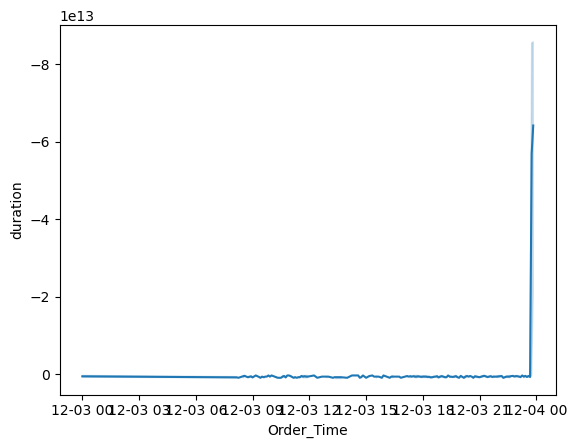

In [ ]:
sns.lineplot(x="Order_Time", y="duration", data=amazon_sample400)

In [ ]:
print(amazon_sample400["duration"].describe())

count                            399
mean     -1 days +23:52:06.315789474
std        0 days 02:40:06.867006413
min                -1 days +00:10:00
25%                  0 days 00:05:00
50%                  0 days 00:10:00
75%                  0 days 00:15:00
max                  0 days 00:15:00
Name: duration, dtype: object
